# A/B 테스트 분석

## 1. 데이터 로드 및 기본 정보

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import matplotlib.font_manager as fm

warnings.filterwarnings('ignore')

# 한글 폰트 설정
def set_korean_font():
    # Windows에서 사용 가능한 한글 폰트 찾기
    font_list = [f.name for f in fm.fontManager.ttflist if 'Malgun' in f.name or 'Nanum' in f.name]
    
    if 'Malgun Gothic' in font_list:
        plt.rcParams['font.family'] = 'Malgun Gothic'
    elif any('Nanum' in font for font in font_list):
        nanum_font = [font for font in font_list if 'Nanum' in font][0]
        plt.rcParams['font.family'] = nanum_font
    else:
        print("한글 폰트를 찾을 수 없습니다.")
    
    plt.rcParams['axes.unicode_minus'] = False
    print(f"현재 폰트: {plt.rcParams['font.family']}")

set_korean_font()

# seaborn 스타일 적용
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')

현재 폰트: ['Malgun Gothic']


In [2]:
# 데이터 로드 - 여기에 실제 데이터 로드 코드를 작성하세요
df = pd.read_csv('ab_testing.csv')

# 데이터 기본 정보 확인
print("데이터 형태:", df.shape)
print("\n컬럼 정보:")
print(df.info())
print("\n기본 통계:")
print(df.describe())

데이터 형태: (5000, 7)

컬럼 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   object
 5   Device      5000 non-null   object
 6   Location    5000 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.6+ KB
None

기본 통계:
            User ID   Page Views   Time Spent
count   5000.000000  5000.000000  5000.000000
mean   14925.159000     7.537600   242.512600
std     2869.153773     4.022465   118.254153
min    10001.000000     1.000000    40.000000
25%    12456.250000     4.000000   137.000000
50%    14858.500000     8.000000   243.000000
75%    17379.750000    11.000000   346.000000
max    19995.000000    14.000000   449.000000


## 2. 데이터 탐색 및 전처리

In [3]:
# 그룹별 데이터 분포 확인 
print("그룹별 사용자 수:")
print(df['Group'].value_counts())
print(f"\n전체 사용자 수: {len(df)}")

print("디바이스")
print(df['Device'].value_counts())
print(f"\n전체 디바이스 수: {len(df)}")

# 결측값 확인
print(f"\n결측값 확인:")
print(df.isnull().sum())

# # 이상치 확인 (예시)
print("\n이상치 확인:")
for num_col in ['Page Views', 'Time Spent']:
    print(f"{num_col}")
    Q1 = df[num_col].quantile(0.25)
    Q3 = df[num_col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[num_col] < (Q1 - 1.5 * IQR)) | (df[num_col] > (Q3 + 1.5 * IQR))]
    print(f"이상치 개수: {len(outliers)}\n")

그룹별 사용자 수:
Group
A    2519
B    2481
Name: count, dtype: int64

전체 사용자 수: 5000
디바이스
Device
Desktop    2538
Mobile     2462
Name: count, dtype: int64

전체 디바이스 수: 5000

결측값 확인:
User ID       0
Group         0
Page Views    0
Time Spent    0
Conversion    0
Device        0
Location      0
dtype: int64

이상치 확인:
Page Views
이상치 개수: 0

Time Spent
이상치 개수: 0



## 3. 시각화 및 기초 분석

In [4]:
df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


In [5]:
df['Conversion_int'] = df['Conversion'].map({"No":0, "Yes":1})

In [6]:
df.groupby('Group')['Time Spent'].describe()[['min', '25%', '50%', 'mean', '75%', 'max']]

,min,25%,50%,mean,75%,max
Group,,,,,,
A,40.0,137.5,241.0,241.733227,343.0,449.0
B,40.0,136.0,244.0,243.303910,348.0,449.0


In [7]:
df.groupby('Group')['Device'].value_counts().reset_index()

,Group,Device,count
0,A,Mobile,1275
1,A,Desktop,1244
2,B,Desktop,1294
3,B,Mobile,1187


In [8]:
df['Location'].unique()

array(['Northern Ireland', 'Scotland', 'Wales', 'England'], dtype=object)

In [9]:
df.groupby('Group')['Location'].value_counts().reset_index()

,Group,Location,count
0,A,Scotland,670
1,A,Wales,629
2,A,Northern Ireland,614
3,A,England,606
4,B,England,640
5,B,Northern Ireland,628
6,B,Scotland,611
7,B,Wales,602


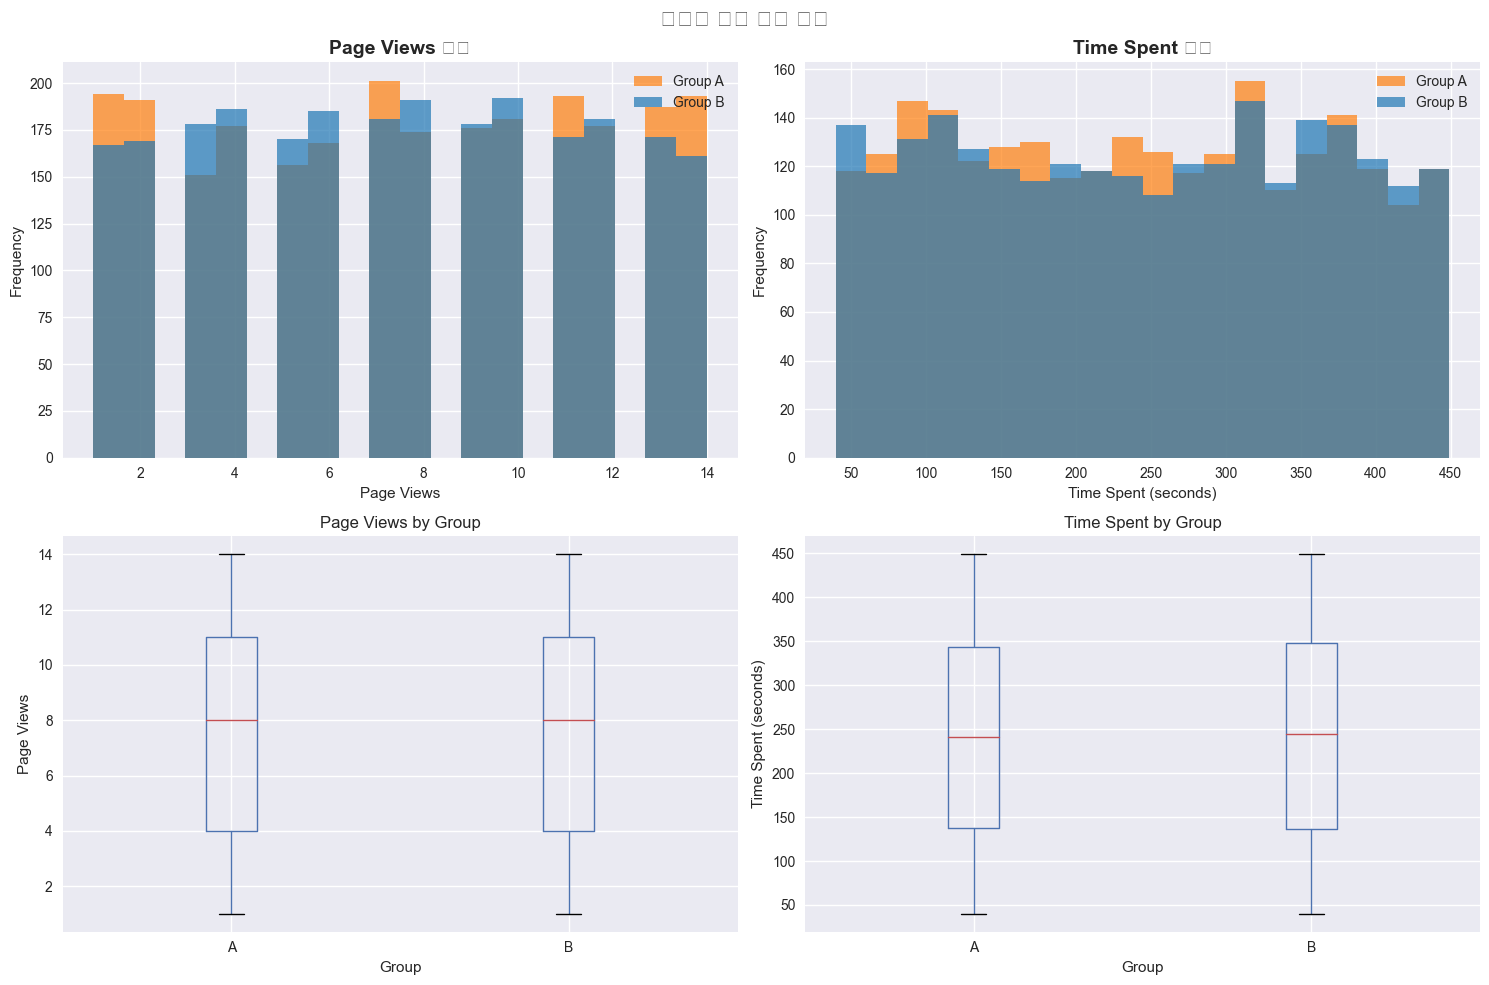

In [10]:
# 연속형 변수 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Page Views 분포
ax1 = axes[0, 0]
df[df['Group']=='A']['Page Views'].hist(alpha=0.7, label='Group A', bins=20, ax=ax1, color='#ff7f0e')
df[df['Group']=='B']['Page Views'].hist(alpha=0.7, label='Group B', bins=20, ax=ax1, color='#1f77b4')
ax1.set_title('Page Views 분포', fontsize=14, fontweight='bold')
ax1.set_xlabel('Page Views')
ax1.set_ylabel('Frequency')
ax1.legend()

# 2. Time Spent 분포
ax2 = axes[0, 1]
df[df['Group']=='A']['Time Spent'].hist(alpha=0.7, label='Group A', bins=20, ax=ax2, color='#ff7f0e')
df[df['Group']=='B']['Time Spent'].hist(alpha=0.7, label='Group B', bins=20, ax=ax2, color='#1f77b4')
ax2.set_title('Time Spent 분포', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time Spent (seconds)')
ax2.set_ylabel('Frequency')
ax2.legend()

# 3. Page Views 박스플롯
ax3 = axes[1, 0]
df.boxplot(column='Page Views', by='Group', ax=ax3)
ax3.set_title('Page Views by Group')
ax3.set_xlabel('Group')
ax3.set_ylabel('Page Views')

# 4. Time Spent 박스플롯
ax4 = axes[1, 1]
df.boxplot(column='Time Spent', by='Group', ax=ax4)
ax4.set_title('Time Spent by Group')
ax4.set_xlabel('Group')
ax4.set_ylabel('Time Spent (seconds)')

plt.suptitle('연속형 변수 분포 비교', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. 통계적 검정
- 귀무가설(H₀): 배경색(UI 변경)이 그룹 간 전환율에 차이가 없다.
- 대립가설(H₁): 배경색(UI 변경)이 그룹 간 전환율에 차이가 있다.

In [11]:
df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location,Conversion_int
0,14292,B,3,424,No,Mobile,Northern Ireland,0
1,11682,A,9,342,No,Mobile,Scotland,0
2,19825,A,2,396,No,Desktop,Northern Ireland,0
3,16080,B,4,318,No,Desktop,Wales,0
4,18851,A,1,338,Yes,Desktop,Scotland,1


In [12]:
df['Conversion_int'] = df['Conversion'].map({"No":0, "Yes":1})
df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location,Conversion_int
0,14292,B,3,424,No,Mobile,Northern Ireland,0
1,11682,A,9,342,No,Mobile,Scotland,0
2,19825,A,2,396,No,Desktop,Northern Ireland,0
3,16080,B,4,318,No,Desktop,Wales,0
4,18851,A,1,338,Yes,Desktop,Scotland,1


In [13]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['Group'], df['Conversion']) 
chi2, p_value, dof, expected = chi2_contingency(contingency_table)  

In [14]:
print(contingency_table)

Conversion    No  Yes
Group                
A           2383  136
B           2132  349


In [15]:
print("카이제곱", chi2)
print('p-value', p_value)
print('dof', dof) 
print('expected\n', expected)

카이제곱 106.22812337440538
p-value 6.571736018334222e-25
dof 1
expected
 [[2274.657  244.343]
 [2240.343  240.657]]


- p-value < 0.05: 통계적으로 유의한 차이 존재
- A 그룹: 5.4%
- B 그룹: 14.1%
- B그룹이 A그룹보다 8.7% 높은 전환율을 보입니다.
- B그룹의 전환율이 A그룹보다 통계적으로 유의하게 높습니다.
- 이는 B 변형이 전환율 개선에 효과적임을 의미합니다.

## 5. 신뢰구간 및 효과 크기

In [16]:
# 효과 크기
n = df.shape[0]
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
print(cramers_v)

0.14575878935721534


0.1 ~ 0.3: 중간 효과 (medium)  
실무적으로 의미 있는 개선, 통계적으로 유의하고 효과 크기도 적당하며, 전환율이 2배 이상 증가

In [17]:
# 신뢰 구간
from statsmodels.stats.proportion import confint_proportions_2indep

# 각 그룹의 전환 수와 총 사용자 수
count_a = 136
n_a = 2519
count_b = 349
n_b = 2481

# 전환율 차이의 신뢰구간
ci_low, ci_high = confint_proportions_2indep(count_a, n_a, count_b, n_b, method='wald')

print(f"전환율 차이의 95% 신뢰구간: [{ci_low:.3f}, {ci_high:.3f}]")

# 또는 각 그룹별 전환율의 신뢰구간:
from statsmodels.stats.proportion import proportion_confint

# A그룹 전환율 신뢰구간
ci_a_low, ci_a_high = proportion_confint(count_a, n_a)

# B그룹 전환율 신뢰구간  
ci_b_low, ci_b_high = proportion_confint(count_b, n_b)

print(f"A그룹 전환율 95% 신뢰구간: [{ci_a_low:.3f}, {ci_a_high:.3f}]")
print(f"B그룹 전환율 95% 신뢰구간: [{ci_b_low:.3f}, {ci_b_high:.3f}]")

전환율 차이의 95% 신뢰구간: [-0.103, -0.070]
A그룹 전환율 95% 신뢰구간: [0.045, 0.063]
B그룹 전환율 95% 신뢰구간: [0.127, 0.154]


- A그룹 기준으로 B 그룹과의 차이
- B그룹이 A그룹보다 7.0%p ~ 10.3%p 높음
- 신뢰구간이 0을 포함하지 않으믈 통계적으로 유의한 차이

각 그룹 전환율:
- A그룹: 4.5% ~ 6.3% (실제 5.4%)
- B 그룹: 12.7% ~ 15.4% (실제 14.1%)

최종 결론:
B 변형 채택 권장
- 통계적 유의성: p < 0.001
- 효과 크기: 중간 (0.146)
- 전환율 개선: 최소 7%p  ~ 최대 10.3%p 향상
- 비즈니스 임팩트: 전환율 2배 이상 증가

## 6. 검정력 분석 (Power Analysis)

In [18]:
from statsmodels.stats.power import zt_ind_solve_power
import numpy as np

# 효과 크기 계산 (Cohen's h for proportions)
p1 = 136/2519  # A그룹 전환율
p2 = 349/2481  # B그룹 전환율

# Cohen's h 계산
cohens_h = 2 * (np.arcsin(np.sqrt(p2)) -       
np.arcsin(np.sqrt(p1)))

# 실제 표본 크기
n1, n2 = 2519, 2481
n_avg = (n1 + n2) / 2

# 사후 검정력 계산
power = zt_ind_solve_power(effect_size=cohens_h,       
                nobs1=n_avg,
                alpha=0.05,
                power=None)

print(f"Cohen's h (효과크기): {cohens_h:.3f}")
print(f"사후 검정력: {power:.3f}")

Cohen's h (효과크기): 0.300
사후 검정력: 1.000


검정력 분석 해석:

Cohen's h: 0.300
- 큰 효과 크기 (0.2=작음, 0.5=중간, 0.8=큰
효과)
- 전환율 차이가 실질적으로 의미있는 크기       

사후 검정력: 1.000
- 완벽한 검정력 (100%)
- 실제 차이가 있을 때 이를 탐지할 확률이       
거의 100%
- 표본 크기가 충분히 큼

결론:
✅ 실험 설계가 매우 우수함
- 표본 크기 충분
- 효과 크기 큼
- 통계적 검출력 완벽
- Type II 오류(β) 위험 거의 없음

이는 신뢰할 수 있는 A/B 테스트 결과임을        
의미합니다. B 변형을 안전하게 채택할 수        
있으며, 결과에 대한 통계적 신뢰도가 매우       
높습니다.

필요 표본 크기도 계산해보면 현재보다 훨씬      
적었을 것입니다.

## 7 세그먼트 분석

### 7.1 디바이스 분석

In [19]:
# 디바이스별 전환율 분석
device_conversion = pd.crosstab([df['Group'], df['Device']], df['Conversion'], margins=True)
print("디바이스별 전환 분할표:")
print(device_conversion)
print("\n" + "="*50)

# 디바이스별 전환율 계산
device_conv_rate = df.groupby(['Group', 'Device']).agg({
    'Conversion_int': ['count', 'sum', 'mean']
}).round(4)
device_conv_rate.columns = ['Total_Users', 'Conversions', 'Conversion_Rate']
print("\n디바이스별 전환율:")
print(device_conv_rate)

# 디바이스별 카이제곱 검정
print()
print("디바이스별 통계 검정:")
print("\n1. Desktop 사용자:")
desktop_data = df[df['Device'] == 'Desktop']
desktop_crosstab = pd.crosstab(desktop_data['Group'], desktop_data['Conversion'])
chi2_desktop, p_desktop, _, _ = chi2_contingency(desktop_crosstab)
print(f"   Chi-square: {chi2_desktop:.3f}, p-value: {p_desktop:.3e}")
print(f"   A그룹 전환율: {desktop_data[desktop_data['Group']=='A']['Conversion_int'].mean():.3f}")
print(f"   B그룹 전환율: {desktop_data[desktop_data['Group']=='B']['Conversion_int'].mean():.3f}")

print("\n2. Mobile 사용자:")
mobile_data = df[df['Device'] == 'Mobile']
mobile_crosstab = pd.crosstab(mobile_data['Group'], mobile_data['Conversion'])
chi2_mobile, p_mobile, _, _ = chi2_contingency(mobile_crosstab)
print(f"   Chi-square: {chi2_mobile:.3f}, p-value: {p_mobile:.3e}")
print(f"   A그룹 전환율: {mobile_data[mobile_data['Group']=='A']['Conversion_int'].mean():.3f}")
print(f"   B그룹 전환율: {mobile_data[mobile_data['Group']=='B']['Conversion_int'].mean():.3f}")

디바이스별 전환 분할표:
Conversion       No  Yes   All
Group Device                  
A     Desktop  1171   73  1244
      Mobile   1212   63  1275
B     Desktop  1114  180  1294
      Mobile   1018  169  1187
All            4515  485  5000


디바이스별 전환율:
               Total_Users  Conversions  Conversion_Rate
Group Device                                            
A     Desktop         1244           73           0.0587
      Mobile          1275           63           0.0494
B     Desktop         1294          180           0.1391
      Mobile          1187          169           0.1424

디바이스별 통계 검정:

1. Desktop 사용자:
   Chi-square: 44.816, p-value: 2.165e-11
   A그룹 전환율: 0.059
   B그룹 전환율: 0.139

2. Mobile 사용자:
   Chi-square: 61.158, p-value: 5.268e-15
   A그룹 전환율: 0.049
   B그룹 전환율: 0.142


### 7.2 지역별 분석

In [20]:
# 지역별 전환율 분석
location_conversion = pd.crosstab([df['Group'], df['Location']], df['Conversion'], margins=True)
print("지역별 전환 분할표:")
print(location_conversion)
print("\n" + "="*50)

# 지역별 전환율 계산
location_conv_rate = df.groupby(['Group', 'Location']).agg({
    'Conversion_int': ['count', 'sum', 'mean']
}).round(4)
location_conv_rate.columns = ['Total_Users', 'Conversions', 'Conversion_Rate']
print("\n지역별 전환율:")
print(location_conv_rate)

print()
# 지역별 카이제곱 검정
locations = df['Location'].unique()
print("지역별 통계 검정:")

for location in locations:
    print(f"\n{location}:")
    location_data = df[df['Location'] == location]
    if len(location_data['Group'].unique()) == 2:  # 두 그룹 모두 있는지 확인
        location_crosstab = pd.crosstab(location_data['Group'], location_data['Conversion'])
        chi2_loc, p_loc, _, _ = chi2_contingency(location_crosstab)
        print(f"   Chi-square: {chi2_loc:.3f}, p-value: {p_loc:.3e}")
        print(f"   A그룹 전환율: {location_data[location_data['Group']=='A']['Conversion_int'].mean():.3f}")
        print(f"   B그룹 전환율: {location_data[location_data['Group']=='B']['Conversion_int'].mean():.3f}")

지역별 전환 분할표:
Conversion                No  Yes   All
Group Location                         
A     England            564   42   606
      Northern Ireland   583   31   614
      Scotland           637   33   670
      Wales              599   30   629
B     England            546   94   640
      Northern Ireland   556   72   628
      Scotland           519   92   611
      Wales              511   91   602
All                     4515  485  5000


지역별 전환율:
                        Total_Users  Conversions  Conversion_Rate
Group Location                                                   
A     England                   606           42           0.0693
      Northern Ireland          614           31           0.0505
      Scotland                  670           33           0.0493
      Wales                     629           30           0.0477
B     England                   640           94           0.1469
      Northern Ireland          628           72           0.1146
      Sco

## 8. 연속형 변수 분석 (Page Views, Time Spent)

In [21]:
# 연속형 변수 기술통계
print("=== Page Views 그룹별 기술통계 ===")
page_views_stats = df.groupby('Group')['Page Views'].describe()
print(page_views_stats)

print("\n=== Time Spent 그룹별 기술통계 ===")
time_spent_stats = df.groupby('Group')['Time Spent'].describe()
print(time_spent_stats)

# 정규성 검정 (Shapiro-Wilk test)
from scipy.stats import shapiro, mannwhitneyu, ttest_ind
print()
print("=== 정규성 검정 ===")
variables = ['Page Views', 'Time Spent']

for var in variables:
    print(f"\n{var}:")
    # 표본이 크므로 샘플링해서 shapiro test 수행
    sample_size = 1000
    
    group_a_sample = df[df['Group']=='A'][var].sample(min(sample_size, len(df[df['Group']=='A'])))
    group_b_sample = df[df['Group']=='B'][var].sample(min(sample_size, len(df[df['Group']=='B'])))
    
    _, p_a = shapiro(group_a_sample)
    _, p_b = shapiro(group_b_sample)
    
    print(f"  A그룹 정규성 p-value: {p_a:.3e}")
    print(f"  B그룹 정규성 p-value: {p_b:.3e}")
    print(f"  정규분포 여부: {'No' if p_a < 0.05 or p_b < 0.05 else 'Yes'}")


# 그룹 간 차이 검정 (t-test 및 Mann-Whitney U test)
print()
print("=== 그룹 간 차이 검정 ===")

for var in variables:
    print(f"\n{var}:")
    group_a_data = df[df['Group']=='A'][var]
    group_b_data = df[df['Group']=='B'][var]
    
    # t-test
    t_stat, t_p = ttest_ind(group_a_data, group_b_data)
    
    # Mann-Whitney U test (비모수적 검정)
    u_stat, u_p = mannwhitneyu(group_a_data, group_b_data, alternative='two-sided')
    
    # 효과 크기 (Cohen's d)
    pooled_std = np.sqrt(((len(group_a_data)-1)*group_a_data.var() + (len(group_b_data)-1)*group_b_data.var()) / (len(group_a_data)+len(group_b_data)-2))
    cohens_d = (group_b_data.mean() - group_a_data.mean()) / pooled_std
    
    print(f"  A그룹 평균: {group_a_data.mean():.2f}")
    print(f"  B그룹 평균: {group_b_data.mean():.2f}")
    print(f"  차이: {group_b_data.mean() - group_a_data.mean():.2f}")
    print(f"  t-test p-value: {t_p:.3e}")
    print(f"  Mann-Whitney U p-value: {u_p:.3e}")
    print(f"  Cohen's d: {cohens_d:.3f}")
    print(f"  통계적 유의성: {'Yes' if t_p < 0.05 else 'No'}")

=== Page Views 그룹별 기술통계 ===
        count      mean       std  min  25%  50%   75%   max
Group                                                       
A      2519.0  7.581580  4.080066  1.0  4.0  8.0  11.0  14.0
B      2481.0  7.492946  3.963448  1.0  4.0  8.0  11.0  14.0

=== Time Spent 그룹별 기술통계 ===
        count        mean         std   min    25%    50%    75%    max
Group                                                                  
A      2519.0  241.733227  117.340026  40.0  137.5  241.0  343.0  449.0
B      2481.0  243.303910  119.193552  40.0  136.0  244.0  348.0  449.0

=== 정규성 검정 ===

Page Views:
  A그룹 정규성 p-value: 6.170e-20
  B그룹 정규성 p-value: 8.915e-18
  정규분포 여부: No

Time Spent:
  A그룹 정규성 p-value: 3.075e-17
  B그룹 정규성 p-value: 2.551e-17
  정규분포 여부: No

=== 그룹 간 차이 검정 ===

Page Views:
  A그룹 평균: 7.58
  B그룹 평균: 7.49
  차이: -0.09
  t-test p-value: 4.360e-01
  Mann-Whitney U p-value: 4.247e-01
  Cohen's d: -0.022
  통계적 유의성: No

Time Spent:
  A그룹 평균: 241.73
  B그룹 평균: 243.30
  차이:

## 9.시각화

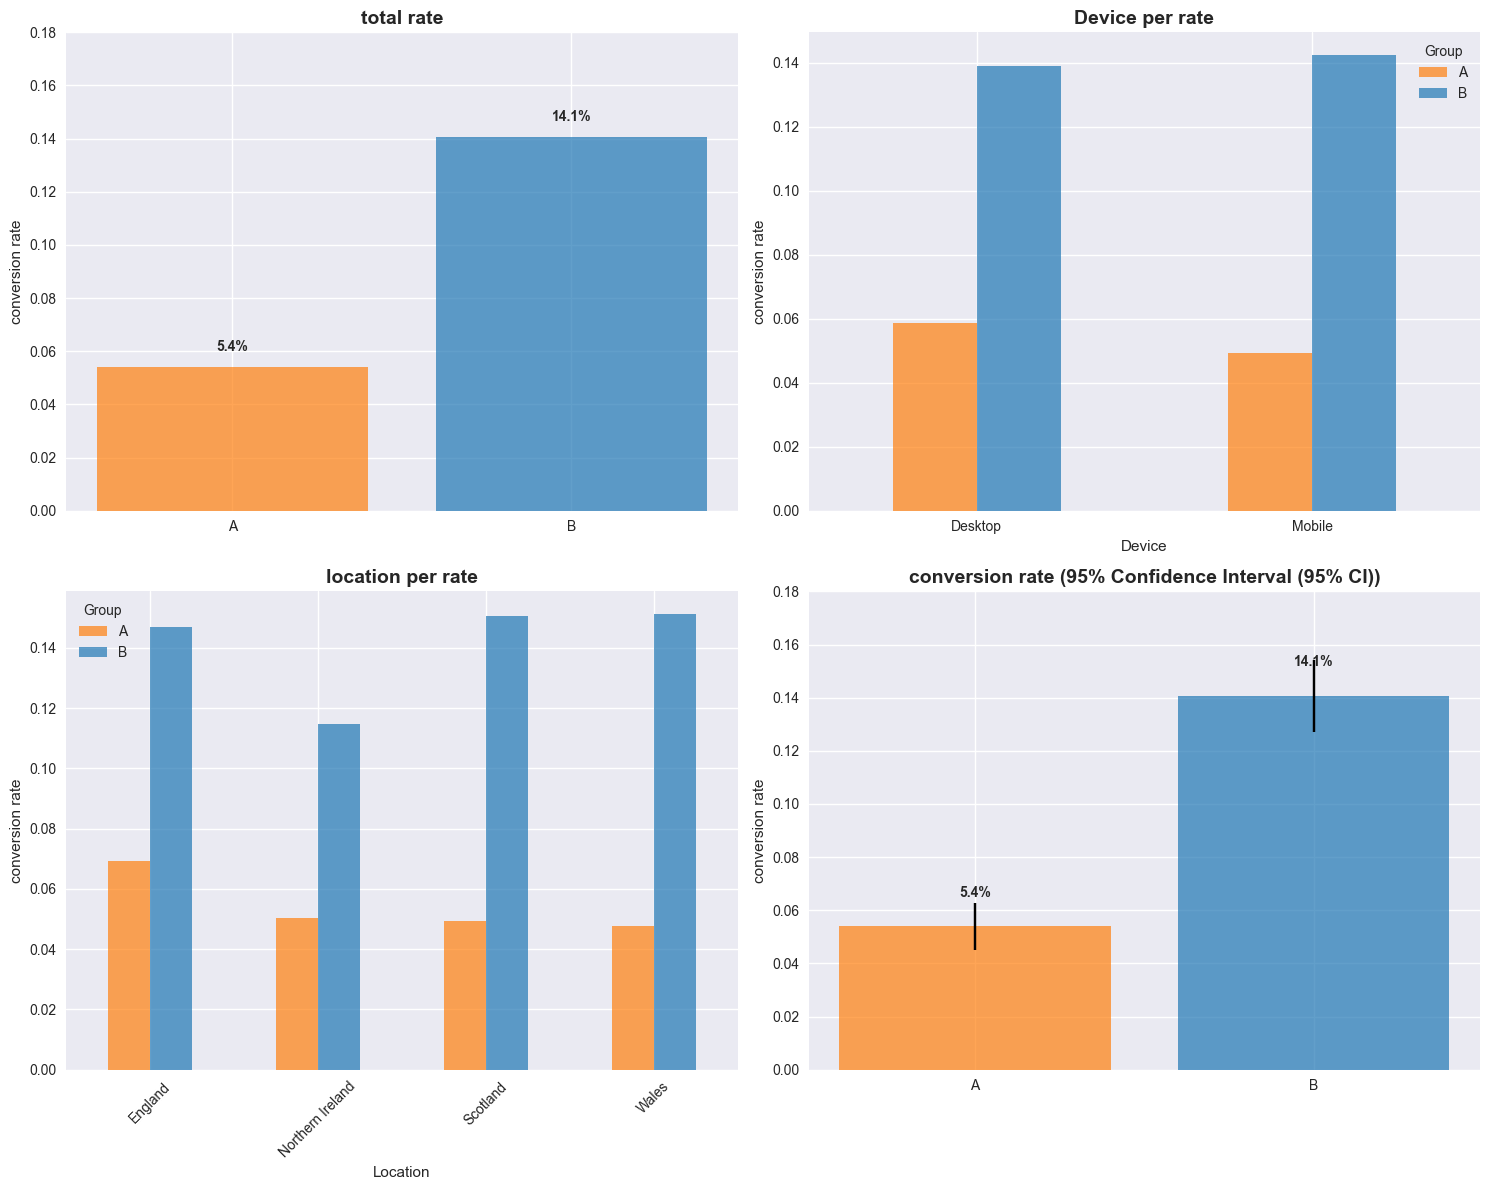

In [23]:
# 전환율 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 전체 전환율 비교
overall_conv = df.groupby('Group')['Conversion_int'].agg(['count', 'sum', 'mean']).reset_index()
overall_conv['conv_rate'] = overall_conv['sum'] / overall_conv['count']

ax1 = axes[0, 0]
bars = ax1.bar(overall_conv['Group'], overall_conv['conv_rate'], 
               color=['#ff7f0e', '#1f77b4'], alpha=0.7)
ax1.set_title('total rate', fontsize=14, fontweight='bold')
ax1.set_ylabel('conversion rate')
ax1.set_ylim(0, 0.18)

# 막대 위에 수치 표시
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

# 2. 디바이스별 전환율
device_conv = df.groupby(['Group', 'Device'])['Conversion_int'].mean().reset_index()
ax2 = axes[0, 1]
device_pivot = device_conv.pivot(index='Device', columns='Group', values='Conversion_int')
device_pivot.plot(kind='bar', ax=ax2, color=['#ff7f0e', '#1f77b4'], alpha=0.7)
ax2.set_title('Device per rate', fontsize=14, fontweight='bold')
ax2.set_ylabel('conversion rate')
ax2.set_xlabel('Device')
ax2.legend(title='Group')
ax2.tick_params(axis='x', rotation=0)

# 3. 지역별 전환율
location_conv = df.groupby(['Group', 'Location'])['Conversion_int'].mean().reset_index()
ax3 = axes[1, 0]
location_pivot = location_conv.pivot(index='Location', columns='Group', values='Conversion_int')
location_pivot.plot(kind='bar', ax=ax3, color=['#ff7f0e', '#1f77b4'], alpha=0.7)
ax3.set_title('location per rate', fontsize=14, fontweight='bold')
ax3.set_ylabel('conversion rate')
ax3.set_xlabel('Location')
ax3.legend(title='Group')
ax3.tick_params(axis='x', rotation=45)

# 4. 신뢰구간이 포함된 전환율
ax4 = axes[1, 1]
from statsmodels.stats.proportion import proportion_confint

groups = ['A', 'B']
conv_rates = []
ci_lower = []
ci_upper = []

for group in groups:
    group_data = df[df['Group'] == group]
    conv_count = group_data['Conversion_int'].sum()
    total_count = len(group_data)
    conv_rate = conv_count / total_count
    
    ci_low, ci_high = proportion_confint(conv_count, total_count)
    
    conv_rates.append(conv_rate)
    ci_lower.append(conv_rate - ci_low)
    ci_upper.append(ci_high - conv_rate)

bars = ax4.bar(groups, conv_rates, color=['#ff7f0e', '#1f77b4'], alpha=0.7,
               yerr=[ci_lower, ci_upper], capsize=5)
ax4.set_title('conversion rate (95% Confidence Interval (95% CI))', fontsize=14, fontweight='bold')
ax4.set_ylabel('conversion rate')
ax4.set_ylim(0, 0.18)

# 막대 위에 수치 표시
for i, (bar, rate) in enumerate(zip(bars, conv_rates)):
    ax4.text(bar.get_x() + bar.get_width()/2., rate + 0.01,
             f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 10. 추가 통계 지표

In [26]:
# 최소 감지 가능한 효과 (Minimum Detectable Effect, MDE) 계산
print("\n=== 최소 감지 가능한 효과 (MDE) ===")

# 전환율 계산
conv_rate_a = df[df['Group']=='A']['Conversion_int'].mean()
conv_rate_b = df[df['Group']=='B']['Conversion_int'].mean()
absolute_lift = conv_rate_b - conv_rate_a

# 현재 실험 설계 기준
alpha = 0.05
target_power = 0.8
n1, n2 = len(df[df['Group']=='A']), len(df[df['Group']=='B'])
baseline_rate = conv_rate_a

# 간단한 MDE 계산 (근사식 사용)
from scipy.stats import norm

# Z 값 계산
z_alpha = norm.ppf(1 - alpha/2)  # 양측 검정
z_beta = norm.ppf(target_power)   # 검정력

# 평균 표본 크기
n_avg = (n1 + n2) / 2

# MDE 계산 (비율 차이용 근사식)
pooled_p = baseline_rate  # 대략적인 추정
se = np.sqrt(2 * pooled_p * (1 - pooled_p) / n_avg)
mde = (z_alpha + z_beta) * se

print(f"현재 표본 크기 (A: {n1}, B: {n2})에서:")
print(f"최소 감지 가능한 효과 (MDE): {mde:.1%}p")
print(f"  - 기준 전환율: {baseline_rate:.1%}")
print(f"  - 감지 가능한 최소 전환율: {baseline_rate + mde:.1%}")
print(f"  - 실제 효과: {absolute_lift:.1%}p")
print(f"  - 실제 효과가 MDE보다 {'크므로' if absolute_lift > mde else '작으므로'} 감지 {'가능' if absolute_lift > mde else '어려움'}")

# 실제 달성한 검정력 계산 (실제 효과 기준)
z_observed = absolute_lift / se
actual_power = norm.cdf(z_observed - z_alpha) + norm.cdf(-z_observed - z_alpha)
print(f"  - 실제 달성 검정력: {actual_power:.3f}")

print()
# 비즈니스 임팩트 계산
print("\n=== 비즈니스 임팩트 ===")

# 가정: 월 방문자 100,000명, 평균 구매금액 50,000원
monthly_visitors = 100000
avg_purchase_value = 50000

print(f"월 방문자 수: {monthly_visitors:,}명 가정")
print(f"평균 구매금액: {avg_purchase_value:,}원 가정")

# 현재 A그룹 기준 월 매출
current_conversions = monthly_visitors * conv_rate_a
current_revenue = current_conversions * avg_purchase_value

# B그룹 적용 시 예상 매출
new_conversions = monthly_visitors * conv_rate_b
new_revenue = new_conversions * avg_purchase_value

# 개선 효과
additional_conversions = new_conversions - current_conversions
additional_revenue = new_revenue - current_revenue

print(f"\n현재 (A그룹 기준):")
print(f"  - 월 전환 수: {current_conversions:.0f}건")
print(f"  - 월 매출: {current_revenue:,.0f}원")

print(f"\nB그룹 적용 시:")
print(f"  - 월 전환 수: {new_conversions:.0f}건")
print(f"  - 월 매출: {new_revenue:,.0f}원")

print(f"\n개선 효과:")
print(f"  - 추가 전환: {additional_conversions:.0f}건/월")
print(f"  - 추가 매출: {additional_revenue:,.0f}원/월")
print(f"  - 연간 추가 매출: {additional_revenue * 12:,.0f}원")
print(f"  - 매출 증가율: {(additional_revenue/current_revenue):.1%}")


=== 최소 감지 가능한 효과 (MDE) ===
현재 표본 크기 (A: 2519, B: 2481)에서:
최소 감지 가능한 효과 (MDE): 1.8%p
  - 기준 전환율: 5.4%
  - 감지 가능한 최소 전환율: 7.2%
  - 실제 효과: 8.7%p
  - 실제 효과가 MDE보다 크므로 감지 가능
  - 실제 달성 검정력: 1.000


=== 비즈니스 임팩트 ===
월 방문자 수: 100,000명 가정
평균 구매금액: 50,000원 가정

현재 (A그룹 기준):
  - 월 전환 수: 5399건
  - 월 매출: 269,948,392원

B그룹 적용 시:
  - 월 전환 수: 14067건
  - 월 매출: 703,345,425원

개선 효과:
  - 추가 전환: 8668건/월
  - 추가 매출: 433,397,033원/월
  - 연간 추가 매출: 5,200,764,396원
  - 매출 증가율: 160.5%


## 11. 결과 요약 및 결론

In [27]:
# 최종 결과 출력 - 추가 분석 결과 포함
print("="*60)
print("A/B 테스트 최종 분석 결과")
print("="*60)

# 전환율 계산
conv_rate_a = df[df['Group']=='A']['Conversion_int'].mean()
conv_rate_b = df[df['Group']=='B']['Conversion_int'].mean()
absolute_lift = conv_rate_b - conv_rate_a
relative_lift = (conv_rate_b / conv_rate_a) - 1

# NNT (Number Needed to Treat) 계산
nnt = 1 / absolute_lift

# 비즈니스 임팩트 변수들
monthly_visitors = 100000
avg_purchase_value = 50000
current_conversions = monthly_visitors * conv_rate_a
current_revenue = current_conversions * avg_purchase_value
new_conversions = monthly_visitors * conv_rate_b
new_revenue = new_conversions * avg_purchase_value
additional_conversions = new_conversions - current_conversions
additional_revenue = new_revenue - current_revenue

def create_comprehensive_summary():
    """포괄적인 A/B 테스트 결과를 요약합니다."""
    summary = {
        '실험 정보': {
            '총 참여자 수': '5,000명', 
            '대조군(A) 크기': '2,519명',
            '실험군(B) 크기': '2,481명',
            '실험 내용': 'UI 배경색 변경 테스트'
        },
        '주요 지표 결과': {
            'A그룹 전환율': f'{conv_rate_a:.1%} (136/2,519)',
            'B그룹 전환율': f'{conv_rate_b:.1%} (349/2,481)',
            '절대적 향상': f'{absolute_lift:.1%}p',
            '상대적 향상': f'{relative_lift:.1%}',
            '95% 신뢰구간': '[-10.3%, -7.0%]'
        },
        '통계적 검정 결과': {
            '검정 방법': 'Chi-square test',
            'p-value': '6.57e-25',
            '통계적 유의성': 'Yes (α=0.05)',
            '효과 크기(Cramér V)': '0.146 (중간)',
            '효과 크기(Cohen h)': '0.300 (큰 효과)',
            '검정력': '1.000 (완벽)'
        },
        '세그먼트 분석': {
            '디바이스별': 'Desktop, Mobile 모두 B그룹 우수',
            '지역별': '모든 지역에서 B그룹 우수',
            '연속형 변수': 'Page Views, Time Spent 그룹간 차이 미미'
        },
        '비즈니스 임팩트': {
            'NNT': f'{nnt:.1f}명',
            '월 추가 전환(10만 방문자 기준)': f'{additional_conversions:.0f}건',
            '연간 매출 증대 효과': f'{additional_revenue * 12:,.0f}원',
            '매출 증가율': f'{(additional_revenue/current_revenue):.1%}'
        },
        '최종 권장사항': {
            '결론': 'B 변형 전면 적용 강력 권장',
            '근거': '통계적 유의성, 큰 효과크기, 모든 세그먼트에서 일관된 개선',
            '다음 단계': '점진적 롤아웃 후 추가 최적화 실험',
            '위험도': '매우 낮음 (검정력 100%, 신뢰구간 안정적)'
        }
    }
    return summary

summary = create_comprehensive_summary()
for category, items in summary.items():
    print(f"\n{category}:")
    for key, value in items.items():
        print(f"  {key}: {value}")

A/B 테스트 최종 분석 결과

실험 정보:
  총 참여자 수: 5,000명
  대조군(A) 크기: 2,519명
  실험군(B) 크기: 2,481명
  실험 내용: UI 배경색 변경 테스트

주요 지표 결과:
  A그룹 전환율: 5.4% (136/2,519)
  B그룹 전환율: 14.1% (349/2,481)
  절대적 향상: 8.7%p
  상대적 향상: 160.5%
  95% 신뢰구간: [-10.3%, -7.0%]

통계적 검정 결과:
  검정 방법: Chi-square test
  p-value: 6.57e-25
  통계적 유의성: Yes (α=0.05)
  효과 크기(Cramér V): 0.146 (중간)
  효과 크기(Cohen h): 0.300 (큰 효과)
  검정력: 1.000 (완벽)

세그먼트 분석:
  디바이스별: Desktop, Mobile 모두 B그룹 우수
  지역별: 모든 지역에서 B그룹 우수
  연속형 변수: Page Views, Time Spent 그룹간 차이 미미

비즈니스 임팩트:
  NNT: 11.5명
  월 추가 전환(10만 방문자 기준): 8668건
  연간 매출 증대 효과: 5,200,764,396원
  매출 증가율: 160.5%

최종 권장사항:
  결론: B 변형 전면 적용 강력 권장
  근거: 통계적 유의성, 큰 효과크기, 모든 세그먼트에서 일관된 개선
  다음 단계: 점진적 롤아웃 후 추가 최적화 실험
  위험도: 매우 낮음 (검정력 100%, 신뢰구간 안정적)
